In [22]:
import functools
import time

import parse_lipidblast as pl
import ml
ml = reload(ml)

import numpy as np
from sklearn import metrics
import sklearn.cross_validation as cv
from sklearn.metrics import confusion_matrix
from scipy.optimize import minimize_scalar

In [23]:
def getCompounds():
    compounds = pl.parse_all(open('combined.txt').read(), sep='\n')
    np.random.seed(0)
    compounds_noisy = ml.add_gauss_noise(compounds, sigma=5e-6)
    return compounds_noisy

In [24]:
def sampleCompounds(compounds, p): #p ... 0 to 1
    #reduces samples from 213000 to 43000 (20%) and features from 58000 to 37000 (63%)
    import random
    return random.sample(compounds, int(len(compounds)*p))

In [25]:
def printMetrics(yresult, ytest):
    for name, sc in zip(('precision', 'recall', 'F1-score'), (metrics.precision_score, metrics.recall_score, metrics.f1_score)):
        score_glob = np.mean([sc(ytrue_, ypred_, average='micro') for ytrue_, ypred_ in zip([ytest], [yresult])])
        score_inv = np.mean([sc(ytrue_, ypred_, average='macro') for ytrue_, ypred_ in zip([ytest], [yresult])])
        print 'Global {}: {}'.format(name, score_glob)
        print 'Inversly-weighted {}: {}'.format(name, score_inv)

In [26]:
compounds = getCompounds()

In [27]:
#X_old, y_old, _old, labels_old = ml.fs_round(compounds)
#print(X_old.shape)
X, y, _, labels = ml.fs_round(sampleCompounds(compounds, 1.0))
print(X.shape)
Xtrain, Xtest, ytrain, ytest = cv.train_test_split(X, y, test_size=0.1, random_state=0)

(212933, 58069)


In [28]:
def classify(Xtrain, Xtest, ytrain, ytest, **params):
    clf = ml.train_bnb(Xtrain, ytrain, **params)
    yresult = clf.predict(Xtest)
    return yresult, sum(yresult == ytest) / float(len(ytest))

In [29]:
def classifyWithRP(Xtrain, Xtest, ytrain, ytest):
    from sklearn.random_projection import johnson_lindenstrauss_min_dim
    from sklearn.random_projection import SparseRandomProjection
    johnson_lindenstrauss_min_dim(Xtrain.shape[0],eps=0.1)
    e = 5
    accuracies = [] 
    for n in range(1,e):
        t0 = time.time()
        Xtr = Xtrain
        Xte = Xtest
        sp = SparseRandomProjection(n_components = int(Xtrain.shape[0]*n/e/2))
        print(int(Xtrain.shape[0]*n/e))
        print(Xtr.shape)
        Xtr = sp.fit_transform(Xtr)
        print(Xtr.shape)
        Xte = sp.transform(Xte)
        yresult, _ = classify(Xtr, Xte, ytrain, ytest)
        printMetrics(yresult, ytest)
        print "Time for bnb Classification with RP preprocessing: {}s".format(time.time() - t0)

In [30]:
def classifyWithFSLV(Xtrain, Xtest, ytrain, ytest): #FeatureSelectionLowVariance (with low variance)
    from sklearn.feature_selection import VarianceThreshold
    accuracies = []
    thresholds = []
    times = []
    e = 6
    for n in range(1,e):
        thresholds.append(.00001*n**3)
    for n in thresholds:
        t0 = time.time()
        Xtr = Xtrain
        Xte = Xtest
        print "For threshold: ", n
        fslv = VarianceThreshold(threshold=(n)) #0.00008 seems to be optimal for fslv in this case
        Xtr = fslv.fit_transform(Xtrain)
        Xte = fslv.transform(Xtest)
        yresult, _ = classify(Xtr, Xte, ytrain, ytest)
        #printMetrics(yresult, ytest)
        print "Achieved accuracy of: ", metrics.accuracy_score(yresult, ytest)
        accuracies.append(metrics.accuracy_score(yresult, ytest))
        times.append(time.time() - t0)
        print "Time for bnb Classification with FSLV preprocessing: {}s".format(time.time() - t0)
    return accuracies, thresholds, times, "Threshold", "Feature Selection with Low Variance"

In [31]:
def classifyWithFSU(Xtrain, Xtest, ytrain, ytest): #FeatureSelectionUnivariate 
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import chi2
    accuracies = []
    k_bests = []
    times = []
    e = 6
    for n in range(1,e):
        k_bests.append(int(Xtrain.shape[0]*n/e/4))
    for n in k_bests:
        t0 = time.time()
        Xtr = Xtrain
        Xte = Xtest
        print "For k-Best: ", n
        skb = SelectKBest(chi2, k=n)
        Xtr = skb.fit_transform(Xtrain, ytrain)
        Xte = skb.transform(Xtest)
        yresult, _ = classify(Xtr, Xte, ytrain, ytest)
        print "Achieved accuracy of: ", metrics.accuracy_score(yresult, ytest)
        accuracies.append(metrics.accuracy_score(yresult, ytest))
        times.append(time.time() - t0)
        print "Time for bnb Classification with FSU preprocessing: {}s".format(time.time() - t0)
    return accuracies, k_bests, times, "SelectKBest", "Univariate Feature Selection"

In [32]:
def compareParameters(arg, baseline, time_unpreprocessed):
    %matplotlib inline
    import matplotlib.pyplot as plt
    accuracies = arg[0]
    parameters = arg[1]
    times = arg[2]
    parametername = arg[3]
    name = arg[4]
    #accuracy and parameter
    plt.figure()
    plt.suptitle(name)
    plt.xlabel(parametername)
    plt.ylabel("Accuracy")
    plt.xlim([min(parameters), max(parameters)])
    plt.ylim([0, 1.0])
    print parameters, [baseline]*len(accuracies), len(accuracies)
    plt.plot(parameters, [baseline]*len(accuracies), color = "r")
    plt.plot(parameters, accuracies)
    plt.show()
    #time and parameter
    plt.figure()
    plt.suptitle(name)
    plt.xlabel(parametername)
    plt.ylabel("Time")
    plt.xlim([min(parameters), max(parameters)])
    times0 = list(times)
    times0.append(time_unpreprocessed)
    plt.ylim(min(times0)-min(times0)*0.1, max(times0)+max(times0)*0.1)
    plt.plot(parameters, [time_unpreprocessed]*len(parameters), color = "r")
    plt.plot(parameters, times)
    plt.show()

In [33]:
classify_ = lambda alph: -classify(Xtrain, Xtest, ytrain, ytest, alpha=alph)[1]
def find_optimal_alpha(bounds=(0,1)):
    res = minimize_scalar(classify_, bounds=bounds, method='bounded')
    return res.x, -res.fun

alpha_max, best_precision = find_optimal_alpha(bounds=(0.01, 0.04))
print "Maximal precision={} for alpha={}".format(best_precision, alpha_max)

Maximal precision=0.943035596882 for alpha=0.0140811255735


In [34]:
#no preprocessing
t0 = time.time()
yresult, _ = classify(Xtrain, Xtest, ytrain, ytest, alpha=alpha_max)
#printMetrics(yresult, ytest)
print "Maximal accuracy={}".format(metrics.accuracy_score(yresult, ytest))
time_unpreprocessed = time.time() - t0
print "Time for classification without preprocessing: {}s".format(time.time() - t0)

Maximal accuracy=0.943035596882
Time for classification without preprocessing: 0.840000152588s


In [38]:
#classifyWithRP(Xtrain, Xtest, ytrain, ytest)

38327
(191639, 58069)
(191639, 19163)
Global precision: 0.852540621771
Inversly-weighted precision: 0.849005691148
Global recall: 0.852540621771
Inversly-weighted recall: 0.809572720922
Global F1-score: 0.852540621771
Inversly-weighted F1-score: 0.80995702572
Time for bnb Classification with RP preprocessing: 41.6740000248s
76655
(191639, 58069)
(191639, 38327)
Global precision: 0.861557246173
Inversly-weighted precision: 0.859573370339
Global recall: 0.861557246173
Inversly-weighted recall: 0.81202229208
Global F1-score: 0.861557246173
Inversly-weighted F1-score: 0.818545932323
Time for bnb Classification with RP preprocessing: 176.237999916s
114983
(191639, 58069)
(191639, 57491)


MemoryError: 

For threshold:  1e-05
Achieved accuracy of:  0.929745468207
Time for bnb Classification with FSLV preprocessing: 0.9390001297s
For threshold:  8e-05
Achieved accuracy of:  0.874283835822
Time for bnb Classification with FSLV preprocessing: 0.793999910355s
For threshold:  0.00027
Achieved accuracy of:  0.731144923453
Time for bnb Classification with FSLV preprocessing: 0.726999998093s
For threshold:  0.00064
Achieved accuracy of:  0.630788015403
Time for bnb Classification with FSLV preprocessing: 0.706000089645s
For threshold:  0.00125
Achieved accuracy of:  0.573307034845
Time for bnb Classification with FSLV preprocessing: 0.691999912262s
[1e-05, 8e-05, 0.00027, 0.00064, 0.00125] [0.94303559688175076, 0.94303559688175076, 0.94303559688175076, 0.94303559688175076, 0.94303559688175076] 5


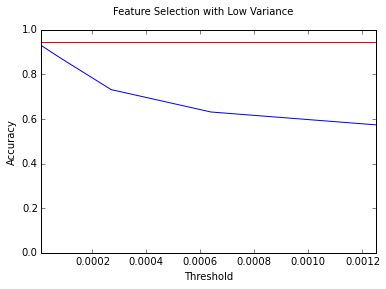

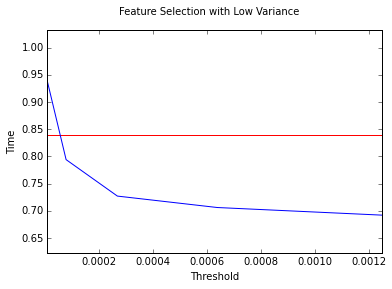

In [36]:
compareParameters(classifyWithFSLV(Xtrain, Xtest, ytrain, ytest), metrics.accuracy_score(yresult, ytest), time_unpreprocessed)
#red: baseline
#blue: accuracies for

For k-Best:  7984
Achieved accuracy of:  0.751714097868
Time for bnb Classification with FSU preprocessing: 1.36800003052s
For k-Best:  15969
Achieved accuracy of:  0.848783694938
Time for bnb Classification with FSU preprocessing: 1.43600010872s
For k-Best:  23954
Achieved accuracy of:  0.898093359632
Time for bnb Classification with FSU preprocessing: 1.47199988365s
For k-Best:  31939
Achieved accuracy of:  0.917676340753
Time for bnb Classification with FSU preprocessing: 1.52900004387s
For k-Best:  39924
Achieved accuracy of:  0.926317272471
Time for bnb Classification with FSU preprocessing: 1.52799987793s
[7984, 15969, 23954, 31939, 39924] [0.94303559688175076, 0.94303559688175076, 0.94303559688175076, 0.94303559688175076, 0.94303559688175076] 5


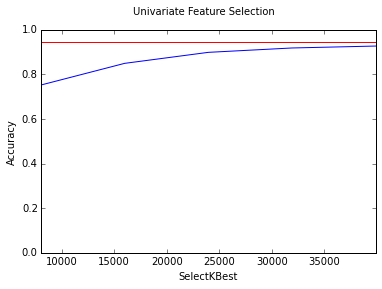

In [37]:
compareParameters(classifyWithFSU(Xtrain, Xtest, ytrain, ytest), metrics.accuracy_score(yresult, ytest), time_unpreprocessed)